## Importing Libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sns

In [62]:
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [98]:
import matplotlib.colors as mcolors

## Reading Dataset

In [63]:
dataset = pd.read_csv('postelectionfinal.csv')

## Understanding the Data

In [64]:
dataset.head()

,method,tweet,username,date,hashtag used for search
0,manual tweetdeck,Online info on government websites going down?...,Jauain,5/16/2022,#halalan2022
1,manual tweetdeck,"NEWS REPORT: Tonight, at exactly 11:19 PM, Vic...",PhilippinePDNS,5/16/2022,#halalan2022
2,manual tweetdeck,JUST IN: Former COMELEC Chairman Andy Bautista...,PhilippinePDNS,5/16/2022,#halalan2022
3,manual tweetdeck,"Lahat ng COC sa #Halalan2022 maliban sa isa, n...",updatesmanila,5/16/2022,#halalan2022
4,manual tweetdeck,BREAKING NEWS: COMELEC will proclaim the winni...,GreenGiantFM,5/16/2022,#halalan2022


In [65]:
dataset.shape

(6641, 5)

In [66]:
dataset.dtypes

method                     object
tweet                      object
username                   object
date                       object
hashtag used for search    object
dtype: object

In [67]:
dataset.describe()

,method,tweet,username,date,hashtag used for search
count,6641,6641,6641,6641,6641
unique,2,5865,2484,21,4
top,manual twitter,#Halalan2022,news5ph,5/11/2022,#halalan2022
freq,6166,19,371,2222,3007


In [68]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6641 entries, 0 to 6640
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   method                   6641 non-null   object
 1   tweet                    6641 non-null   object
 2   username                 6641 non-null   object
 3   date                     6641 non-null   object
 4   hashtag used for search  6641 non-null   object
dtypes: object(5)
memory usage: 259.5+ KB


In [69]:
dataset.isna().sum()

method                     0
tweet                      0
username                   0
date                       0
hashtag used for search    0
dtype: int64

## Data Cleaning

In [70]:
#Raw Dataset
dataset

,method,tweet,username,date,hashtag used for search
0,manual tweetdeck,Online info on government websites going down?...,Jauain,5/16/2022,#halalan2022
1,manual tweetdeck,"NEWS REPORT: Tonight, at exactly 11:19 PM, Vic...",PhilippinePDNS,5/16/2022,#halalan2022
2,manual tweetdeck,JUST IN: Former COMELEC Chairman Andy Bautista...,PhilippinePDNS,5/16/2022,#halalan2022
3,manual tweetdeck,"Lahat ng COC sa #Halalan2022 maliban sa isa, n...",updatesmanila,5/16/2022,#halalan2022
4,manual tweetdeck,BREAKING NEWS: COMELEC will proclaim the winni...,GreenGiantFM,5/16/2022,#halalan2022
...,...,...,...,...,...
6636,manual twitter,Dictator Ferdinand Marcos from the Philippines...,tayomuna,5/28/2022,#Election2022PH
6637,manual twitter,This election rewrites history. People voted f...,kollenedoncillo,5/28/2022,#Election2022PH
6638,manual twitter,"Hey, it’s a free country. No one has monopoly ...",joel_gregorio,5/28/2022,#Election2022PH
6639,manual twitter,HALA-lan. \n\n#Election2022PH,keithjumaani,5/29/2022,#Election2022PH


In [71]:
#1 Drop unnecessary columns

dataset.drop(['method','username','date','hashtag used for search'], axis=1, inplace=True)
dataset

,tweet
0,Online info on government websites going down?...
1,"NEWS REPORT: Tonight, at exactly 11:19 PM, Vic..."
2,JUST IN: Former COMELEC Chairman Andy Bautista...
3,"Lahat ng COC sa #Halalan2022 maliban sa isa, n..."
4,BREAKING NEWS: COMELEC will proclaim the winni...
...,...
6636,Dictator Ferdinand Marcos from the Philippines...
6637,This election rewrites history. People voted f...
6638,"Hey, it’s a free country. No one has monopoly ..."
6639,HALA-lan. \n\n#Election2022PH


In [72]:
#Get the exact duplicate tweets in the dataframe
print("Duplicate Tweets:", len(dataset['tweet'])-len(dataset['tweet'].drop_duplicates()))

Duplicate Tweets: 776


In [73]:
# 2 Remove Exact Duplicate Tweets
# Drop the last duplicate and keep the first one
dataset.drop_duplicates(subset='tweet', keep="first", inplace=True)
dataset = dataset.reset_index()

In [74]:
dataset.drop(['index'], axis=1, inplace=True)
dataset

,tweet
0,Online info on government websites going down?...
1,"NEWS REPORT: Tonight, at exactly 11:19 PM, Vic..."
2,JUST IN: Former COMELEC Chairman Andy Bautista...
3,"Lahat ng COC sa #Halalan2022 maliban sa isa, n..."
4,BREAKING NEWS: COMELEC will proclaim the winni...
...,...
5860,Dictator Ferdinand Marcos from the Philippines...
5861,This election rewrites history. People voted f...
5862,"Hey, it’s a free country. No one has monopoly ..."
5863,HALA-lan. \n\n#Election2022PH


In [75]:
# Get the percentage of emojis in the dataset
def calculate_percentage_of_emojis(text):
    emoji_pattern = re.compile(r'\p{Emoji}')
    
    emojis = emoji_pattern.findall(text)
    
    # Calculate the percentage of Unicode emojis
    total_chars = len(text)
    if total_chars > 0:
        percentage = (len(emojis) / total_chars) * 100
    else:
        percentage = 0
    return percentage

overall_percentage_of_emojis = dataset['tweet'].apply(calculate_percentage_of_emojis).mean()

print(f"Overall Percentage of Emojis in the Dataset: {overall_percentage_of_emojis:.2f}%")

Overall Percentage of Emojis in the Dataset: 6.75%


In [76]:
# 3 Transform Emojis to Text
def transform_emojis(text):
    text = emoji.demojize(text, delimiters=(" ", " "))
    return text

dataset['tweet'] = dataset['tweet'].apply(transform_emojis)
dataset

,tweet
0,Online info on government websites going down?...
1,"NEWS REPORT: Tonight, at exactly 11:19 PM, Vic..."
2,JUST IN: Former COMELEC Chairman Andy Bautista...
3,"Lahat ng COC sa #Halalan2022 maliban sa isa, n..."
4,BREAKING NEWS: COMELEC will proclaim the winni...
...,...
5860,Dictator Ferdinand Marcos from the Philippines...
5861,This election rewrites history. People voted f...
5862,"Hey, it’s a free country. No one has monopoly ..."
5863,HALA-lan. \n\n#Election2022PH


In [77]:
# 4 Replace "#" with the word "hashtag" in the "Tweets" column
dataset['tweet'] = dataset['tweet'].str.replace("#", "hashtag")
dataset

,tweet
0,Online info on government websites going down?...
1,"NEWS REPORT: Tonight, at exactly 11:19 PM, Vic..."
2,JUST IN: Former COMELEC Chairman Andy Bautista...
3,Lahat ng COC sa hashtagHalalan2022 maliban sa ...
4,BREAKING NEWS: COMELEC will proclaim the winni...
...,...
5860,Dictator Ferdinand Marcos from the Philippines...
5861,This election rewrites history. People voted f...
5862,"Hey, it’s a free country. No one has monopoly ..."
5863,HALA-lan. \n\nhashtagElection2022PH


In [78]:
# 5 Remove non-alphanumeric characters, spaces & links
def clean_text(text):
    text = text.replace('?', ' ').replace('!', ' ') # Remove question marks, exclamation points
    text = ' '.join([word for word in text.split() if not word.startswith('@')]) # Remove mention tags
    text = text.replace('\n', ' ') # Remove newline characters

    # Remove all non-alphanumeric characters except hashtags, underscores, and spaces
    text = re.sub(r'[^a-zA-Z0-9_#\s]', '', text)

    # Remove links (http/s and youtube)
    text = ' '.join([word for word in text.split() if not word.startswith(('http://', 'https://', 'youtube', 'youtu be'))]) 
    text = text.replace('...', ' ') # Remove ellipses
    text = ' '.join(text.split()) # Replace multiple spaces with a single space
    text = text.strip() # Remove leading/trailing spaces
    return text

dataset['tweet'] = dataset['tweet'].apply(clean_text)
print(dataset)

                                                  tweet
0     Online info on government websites going down ...
1     NEWS REPORT Tonight at exactly 1119 PM Vice Pr...
2     JUST IN Former COMELEC Chairman Andy Bautista ...
3     Lahat ng COC sa hashtagHalalan2022 maliban sa ...
4     BREAKING NEWS COMELEC will proclaim the winnin...
...                                                 ...
5860  Dictator Ferdinand Marcos from the Philippines...
5861  This election rewrites history People voted fo...
5862  Hey its a free country No one has monopoly of ...
5863                      HALAlan hashtagElection2022PH
5864  Cheating malalim na sugat kahit mahilom mahira...

[5865 rows x 1 columns]


In [79]:
# 6 Tokenization
# nltk.download('punkt')

dataset['Tokenized_Tweets'] = dataset['tweet'].apply(lambda x: word_tokenize(x))

dataset['Tokenized_Tweets']

0       [Online, info, on, government, websites, going...
1       [NEWS, REPORT, Tonight, at, exactly, 1119, PM,...
2       [JUST, IN, Former, COMELEC, Chairman, Andy, Ba...
3       [Lahat, ng, COC, sa, hashtagHalalan2022, malib...
4       [BREAKING, NEWS, COMELEC, will, proclaim, the,...
                              ...                        
5860    [Dictator, Ferdinand, Marcos, from, the, Phili...
5861    [This, election, rewrites, history, People, vo...
5862    [Hey, its, a, free, country, No, one, has, mon...
5863                     [HALAlan, hashtagElection2022PH]
5864    [Cheating, malalim, na, sugat, kahit, mahilom,...
Name: Tokenized_Tweets, Length: 5865, dtype: object

In [80]:
# 7 Case Transformation
# Function to transform tokenized tweets to lowercase
def lowercase_tokens(tokens):
    return [token.lower() for token in tokens]

dataset['Tokenized_Tweets'] = dataset['Tokenized_Tweets'].apply(lambda x: lowercase_tokens(x))
print(dataset['Tokenized_Tweets'])

0       [online, info, on, government, websites, going...
1       [news, report, tonight, at, exactly, 1119, pm,...
2       [just, in, former, comelec, chairman, andy, ba...
3       [lahat, ng, coc, sa, hashtaghalalan2022, malib...
4       [breaking, news, comelec, will, proclaim, the,...
                              ...                        
5860    [dictator, ferdinand, marcos, from, the, phili...
5861    [this, election, rewrites, history, people, vo...
5862    [hey, its, a, free, country, no, one, has, mon...
5863                     [halalan, hashtagelection2022ph]
5864    [cheating, malalim, na, sugat, kahit, mahilom,...
Name: Tokenized_Tweets, Length: 5865, dtype: object


In [81]:
import csv

In [82]:
# Create Abbreviation Dictionary
abbreviation_dict = {}
abbreviation = pd.read_csv('abbreviation.csv')
with open('abbreviation.csv', mode='r') as inp:
  reader = csv.reader(inp)
  abbreviation_dict = {rows[0]:rows[1] for rows in reader}
abbreviation_dict

{'88m': 'bbm',
 'accling': 'queer',
 'ad': 'advertisement',
 'agri': 'agricultural',
 'amp ': 'ang puta',
 'ampalaya': 'bitter',
 'anniv': 'anniversary',
 'app': 'application',
 'ar': 'augmented reality',
 'atty': 'attorney',
 'ave': 'avenue',
 'b4': 'before',
 'babym': 'bbm',
 'bcoz': 'because',
 'bcs': 'because',
 'bec': 'because',
 'beh': 'best friend',
 'bei': 'board of election inspector',
 'bes': 'best friend',
 'besh': 'best friend',
 'beshie': 'best friend',
 'beybiem': 'bbm',
 'bgy': 'barangay',
 'bishies': 'best friend',
 'blengbong': 'bongbong',
 'bp': 'bise presidente',
 'brgy': 'barangay',
 'brgys': 'barangays',
 'bs': 'bull shit',
 'bugok': 'stupid',
 'bull': 'ridiculous',
 'camsur': 'camarines sur',
 'chariz': 'joke',
 'charot': 'joke',
 'charots': 'joke',
 'clav': 'commitee on local absentee voting',
 'cmd': 'christian muslim democrats',
 'coc': 'certificate of candidacy',
 'cocs': 'certificate of candidacy',
 'coe': 'commission on elections',
 'comm ': 'commision',
 'c

In [83]:
# 8 Abbreviation Transformation
def transform_abbreviations_within_tokens(tokens, abbreviation_dict):
    transformed_tokens = []
    
    for token in tokens:
        words = token.split()
        transformed_words = []
        
        for word in words:
            if word in abbreviation_dict:
                transformed_words.append(abbreviation_dict[word])
            else:
                transformed_words.append(word)
        
        transformed_token = ' '.join(transformed_words)
        transformed_tokens.append(transformed_token)
    
    return transformed_tokens

dataset['Tokenized_Tweets'] = dataset['Tokenized_Tweets'].apply(lambda x: transform_abbreviations_within_tokens(x, abbreviation_dict))
print(dataset['Tokenized_Tweets'])

0       [online, info, on, government, websites, going...
1       [news, report, tonight, at, exactly, 1119, pm,...
2       [just, in, former, comelec, chairman, andy, ba...
3       [lahat, ng, certificate of candidacy, sa, hash...
4       [breaking, news, comelec, will, proclaim, the,...
                              ...                        
5860    [dictator, ferdinand, marcos, from, the, phili...
5861    [this, election, rewrites, history, people, vo...
5862    [hey, its, a, free, country, no, one, has, mon...
5863                     [halalan, hashtagelection2022ph]
5864    [cheating, malalim, na, sugat, kahit, mahilom,...
Name: Tokenized_Tweets, Length: 5865, dtype: object


In [84]:
# 9 Misspelled Words Transformation
from chardet import detect
from spellchecker import SpellChecker
import nltk
from nltk.tokenize import word_tokenize

spell_checker_en = SpellChecker()

tagalog_word_list = []
with open('tl_PH.aff', 'r', encoding='utf-8') as word_list_file:
    tagalog_word_list = [line.strip() for line in word_list_file]


def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown" 
def correct_words(tokens):
    language = detect_language(' '.join(tokens))
    
    corrected_tokens = [
        spell_checker_en.correction(word) if language == 'en' else
        word.lower() if language == 'tl' and word.lower() in tagalog_word_list else
        word
        for word in tokens
    ]

    return corrected_tokens

dataset['Corrected_Words'] = dataset['Tokenized_Tweets'].apply(correct_words)
print(dataset['Corrected_Words'])

0       [online, info, on, government, websites, going...
1       [news, report, tonight, at, exactly, 1119, pm,...
2       [just, in, former, comelec, chairman, andy, ba...
3       [lahat, ng, certificate of candidacy, sa, hash...
4       [breaking, news, comelec, will, proclaim, the,...
                              ...                        
5860    [dictator, ferdinand, marcos, from, the, phili...
5861    [this, election, rewrites, history, people, vo...
5862    [hey, its, a, free, country, no, one, has, mon...
5863                     [halalan, hashtagelection2022ph]
5864    [cheating, malalim, na, sugat, kahit, mahilom,...
Name: Corrected_Words, Length: 5865, dtype: object


In [85]:
# Store Stopwords
tag_stopwords = (['akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'ba', 'bababa', 'bago', 'bakit', 'bawat', 'bilang', 'eh', 'dahil', 'dalawa', 'dapat','daw', 'din', 'dito', 'doon', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan','ilang', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino','kaniyang', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan', 'katiyakan', 'katulad', 'kasi', 'kay', 'kaya','kayo', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang','lang', 'likod', 'lima', 'ma', 'maaari', 'maaaring', 'mag', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo','mo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'naman', 'namin', 'nang', 'napaka', 'nasa', 'narito', 'nasaan','natin', 'ng', 'nga', 'ngayon', 'ni', 'nila', 'nilang', 'nito', 'niya', 'niyang','niyo', 'noon', 'noong', 'nyo', 'o', 'pa', 'pala', 'pag', 'paano', 'pababa', 'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'palabas', 'pamamagitan', 'panahon', 'pangalawa', 'para', 'paraan', 'pareho', 'pataas', 'pero', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi', 'sabihin', 'sarili', 'sila', 'sino', 'siya','rin', 'tatlo', 'tayo','talaga', 'tulad', 'tungkol', 'una', 'wala', 'walang','wag', 'yan', 'yung'])
eng_stopwords = (" k","0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't","dont", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz")

# Combine and sort the two
combined_stopwords = sorted(list(tag_stopwords) + list(eng_stopwords))

total_stopwords = len(combined_stopwords)

print(f"Total Combined Stopwords: {total_stopwords}")

Total Combined Stopwords: 1337


In [86]:
# 11 Stopwords Removal
for i, tokens in enumerate(dataset['Corrected_Words']):
    filtered_tokens = []
    for word in tokens:
        if word not in combined_stopwords:
            filtered_tokens.append(word)
    dataset['Corrected_Words'][i] = filtered_tokens

print(dataset)

                                                  tweet  \
0     Online info on government websites going down ...   
1     NEWS REPORT Tonight at exactly 1119 PM Vice Pr...   
2     JUST IN Former COMELEC Chairman Andy Bautista ...   
3     Lahat ng COC sa hashtagHalalan2022 maliban sa ...   
4     BREAKING NEWS COMELEC will proclaim the winnin...   
...                                                 ...   
5860  Dictator Ferdinand Marcos from the Philippines...   
5861  This election rewrites history People voted fo...   
5862  Hey its a free country No one has monopoly of ...   
5863                      HALAlan hashtagElection2022PH   
5864  Cheating malalim na sugat kahit mahilom mahira...   

                                       Tokenized_Tweets  \
0     [online, info, on, government, websites, going...   
1     [news, report, tonight, at, exactly, 1119, pm,...   
2     [just, in, former, comelec, chairman, andy, ba...   
3     [lahat, ng, certificate of candidacy, sa, hash...

In [87]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# 12 Function to remove numbers
def remove_numbers_and_blank_spaces(tokens):
    number_pattern = r'\d+'
    tokens_without_numbers = []
    
    for token in tokens:
        token_without_numbers = re.sub(number_pattern, '', token).strip()
        if token_without_numbers:
            tokens_without_numbers.append(token_without_numbers)
    
    return tokens_without_numbers

# 13 Function to remove hashtags used
def remove_hashtags(tokens):
    hashtags_to_remove = ['hashtaghalalan', 'hashtagbilangpilipino', 'hashtagelectionph','hashtageleksyon']
    return [token for token in tokens if token not in hashtags_to_remove]

# 14 Function for lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def preprocess_text(text):
    # Apply lemmatization
    lemmatized_tokens = lemmatize_tokens(text)
    
    # Remove numbers and hashtags
    tokens_without_numbers = remove_numbers_and_blank_spaces(lemmatized_tokens)
    tokens_without_hashtags = remove_hashtags(tokens_without_numbers)
    
    cleaned_text = ', '.join(tokens_without_hashtags)
    
    return cleaned_text

dataset['Corrected_Words'] = dataset['Corrected_Words'].apply(preprocess_text)
print(dataset['Corrected_Words'])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\casti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       online, info, government, website, archive, ht...
1       news, report, tonight, vice, president, leni, ...
2       comelec, chairman, andy, bautista, confirms, a...
3       certificate of candidacy, maliban, nabilang, c...
4       breaking, news, comelec, proclaim, winning, se...
                              ...                        
5860    dictator, ferdinand, marcos, philippine, featu...
5861    election, rewrite, history, people, voted, per...
5862    hey, free, country, monopoly, knowledge, elect...
5863                                              halalan
5864    cheating, malalim, sugat, mahilom, mahirap, ka...
Name: Corrected_Words, Length: 5865, dtype: object


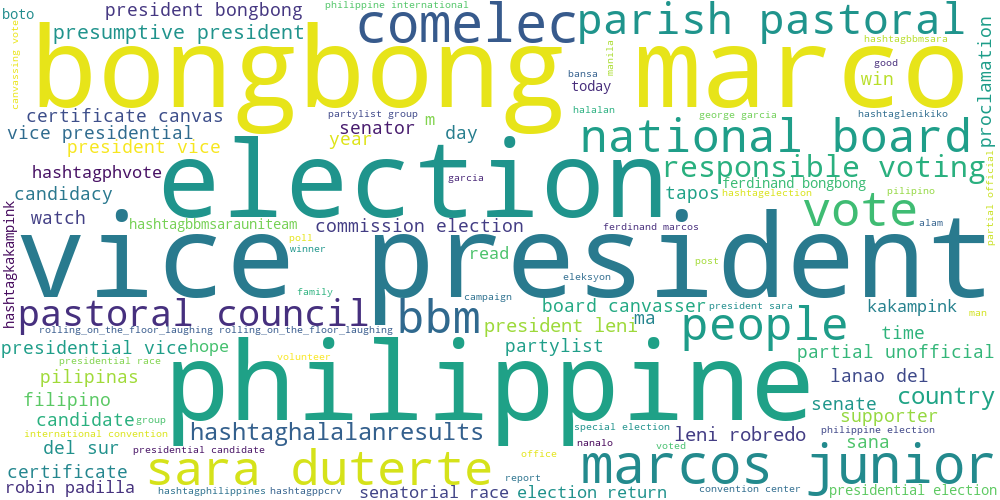

In [88]:
# The use of wordcloud to check if all steps were done correctly
long_string = ','.join(list(dataset['Corrected_Words'].values))
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue', width=1000, height=500)
wordcloud.generate(long_string)
wordcloud.to_image()

## Topic Modeling

In [89]:
import gensim
from gensim import corpora
import numpy as np

documents = dataset['Corrected_Words'].values
tokenized_documents = [doc.split(",") for doc in documents] 

#Create Dictionary
id2word = corpora.Dictionary(tokenized_documents)

#Create Corpus
texts = tokenized_documents

#Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in tokenized_documents] 

In [90]:
# Build the LDA model
num_topics = 4 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=15,
                                            random_state=42,chunksize=50,per_word_topics=True)
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.054*" marcos" + 0.036*" bongbong" + 0.026*" duterte" + 0.023*" sara" + 0.020*" junior" + 0.014*" presidentelect" + 0.010*" ferdinand" + 0.007*" romualdez" + 0.007*" secretary" + 0.006*" kongreso"
Topic 1: 0.018*" leni" + 0.010*" robredo" + 0.008*" filipino" + 0.008*" boto" + 0.008*" enraged_face" + 0.007*" vice president" + 0.006*" year" + 0.006*" vote" + 0.006*"election" + 0.005*" hashtaghalalanph"
Topic 2: 0.021*" philippine" + 0.013*" country" + 0.010*" election" + 0.009*" hashtagphilippines" + 0.008*" people" + 0.008*" rolling_on_the_floor_laughing" + 0.008*" leader" + 0.007*" majority" + 0.007*" pilipinas" + 0.006*" bbm"
Topic 3: 0.041*" president" + 0.025*" election" + 0.020*" vice" + 0.018*" vote" + 0.013*" canvassing" + 0.012*" presidential" + 0.011*" senator" + 0.010*" canvas" + 0.010*" comelec" + 0.009*" candidate"


In [91]:
document_topics = []
for doc_bow in corpus:
    topics = lda_model[doc_bow]
    document_topics.append(topics)

print(f"Topics for Post-Election Tweets: {document_topics[0]}")

Topics for Post-Election Tweets: ([(0, 0.49591368), (1, 0.03527438), (2, 0.43540102), (3, 0.033410884)], [(0, [2, 0, 1]), (1, [2]), (2, [2, 0]), (3, [0, 2]), (4, [0, 2]), (5, [0]), (6, [0, 2])], [(0, [(0, 0.42741102), (1, 0.0106347455), (2, 0.5597647)]), (1, [(2, 0.99961233)]), (2, [(0, 0.14315411), (2, 0.8107692)]), (3, [(0, 0.49709493), (2, 0.3333942)]), (4, [(0, 0.96204925), (2, 0.025426116)]), (5, [(0, 0.99704754)]), (6, [(0, 0.49709493), (2, 0.3333942)])])


### Coherence Score

In [92]:

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3964682018123875


### Finding the Optimal Number of Topics

In [93]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, random_state=100,
        #                                         chunksize=200, passes=15, 
        #                                         per_word_topics=True, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=15,
                                            random_state=42,chunksize=50,per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [94]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=8, step=1)

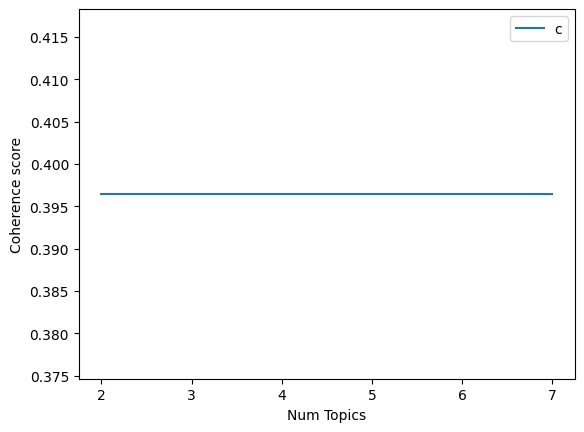

In [95]:
limit=8
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"),loc='best')
plt.show()

In [96]:
for m, cv in zip(x, coherence_values):
    print("Number of Topics =", m, "has Coherence Value of", round(cv,4))

Number of Topics = 2 has Coherence Value of 0.3965
Number of Topics = 3 has Coherence Value of 0.3965
Number of Topics = 4 has Coherence Value of 0.3965
Number of Topics = 5 has Coherence Value of 0.3965
Number of Topics = 6 has Coherence Value of 0.3965
Number of Topics = 7 has Coherence Value of 0.3965


### Topic Modeling Visualization

In [114]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(background_color='white', width=2500, height=2800, max_words=20,
                         colormap='tab10', color_func=lambda * args, **kwargs: cols[i],
                         prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
topics

[(0,
  [(' marcos', 0.053814564),
   (' bongbong', 0.035934493),
   (' duterte', 0.025977802),
   (' sara', 0.022571327),
   (' junior', 0.019845758),
   (' presidentelect', 0.013907782),
   (' ferdinand', 0.010312096),
   (' romualdez', 0.0070391456),
   (' secretary', 0.0066734557),
   (' kongreso', 0.006239967)]),
 (1,
  [(' leni', 0.018250715),
   (' robredo', 0.010309652),
   (' filipino', 0.00830592),
   (' boto', 0.007942195),
   (' enraged_face', 0.007882778),
   (' vice president', 0.0073265033),
   (' year', 0.006423732),
   (' vote', 0.005853323),
   ('election', 0.0055442066),
   (' hashtaghalalanph', 0.0053265435)]),
 (2,
  [(' philippine', 0.020819556),
   (' country', 0.013031565),
   (' election', 0.009656787),
   (' hashtagphilippines', 0.008720631),
   (' people', 0.008222772),
   (' rolling_on_the_floor_laughing', 0.008183711),
   (' leader', 0.008046763),
   (' majority', 0.0073133097),
   (' pilipinas', 0.006951145),
   (' bbm', 0.00647541)]),
 (3,
  [(' president'

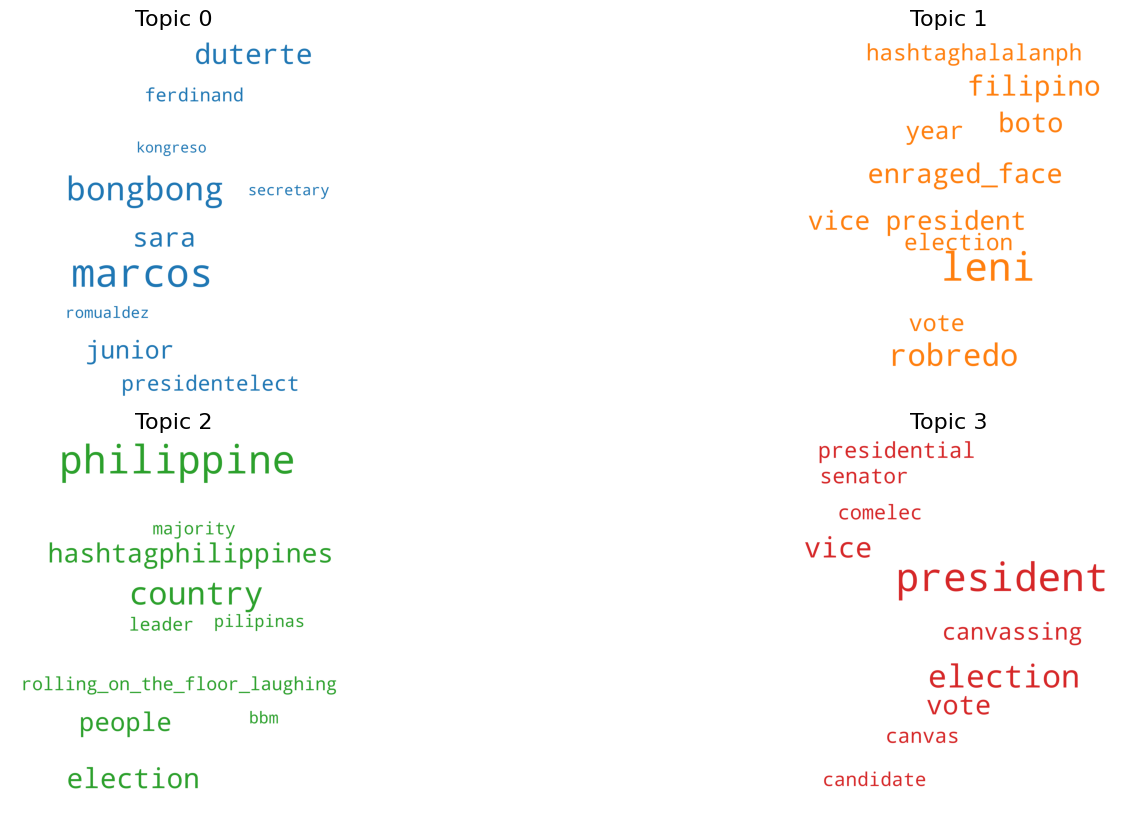

In [120]:
fig, axes = plt.subplots(2,2, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words,max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic '+ str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0.1)
plt.axis('off')
plt.margins(x=0,y=0)
plt.tight_layout
plt.show()
